The goal of this notebook is to prepare and perform an exploratory data analysis (EDA) specifically on the application dataset, utilizing a combination of tabular and visual techniques. In this notebook, *3_2_cleaning_app_data*, we’ll focus on identifying outliers, removing specific flag features, and especially engineering new features. This will serve as a comparison model to the baseline model in *3_1_cleaning_app_data*. This approach will allow us to better understand the impact of **new feature engineering** on model performance.


In [2]:
import pandas as pd
import numpy as np

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# import the functions from the file
from notebook_setup import RootPath, config
from my_functions import pie_plot

# import the functions from the file
from my_functions import (
    convert_to_categorical, 
    encode_and_one_hot, 
    summarize_dataframe,
    detect_outliers_iqr_all, 
    winsorize_selected_features, 
    plot_histogram,
    plot_selected_histograms, 
    transform_to_log, 
    plot_qq_hist,
    kolmogorov_smirnov_test, 
    box_cox_transform, 
    apply_robust_scaling,
    get_top_correlations,
    plot_top_correlation_heatmap,
    missing_values_table, 
    merge_data_on_index
)

# Automatically Reload Changes if there are frequent changes to my xx.py file
%load_ext autoreload
%autoreload 2

In [3]:
# load the application sampled data
app_sample = pd.read_csv(f'{config.CleanDataPath}app_sample.csv', index_col='SK_ID_CURR')
# Drop any columns that contain "Unnamed" in their name
app_sample = app_sample.loc[:, ~app_sample.columns.str.contains('^Unnamed')]
app_sample

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
307474,0,Cash loans,F,Y,N,0,67500.0,1030302.0,40860.0,832500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
412537,0,Cash loans,F,Y,Y,0,90000.0,253737.0,26775.0,229500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
149084,0,Cash loans,M,Y,Y,0,270000.0,1006920.0,45499.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
364692,0,Cash loans,M,Y,Y,2,202500.0,495351.0,29497.5,459000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
155423,0,Cash loans,M,Y,Y,0,162000.0,264159.0,13617.0,220500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356531,0,Cash loans,F,Y,Y,0,247500.0,675000.0,29731.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
336872,1,Cash loans,F,N,N,0,270000.0,634482.0,20596.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
375274,0,Cash loans,F,N,N,0,202500.0,1288350.0,37800.0,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


TARGET
0    28270
1     2481
Name: count, dtype: int64


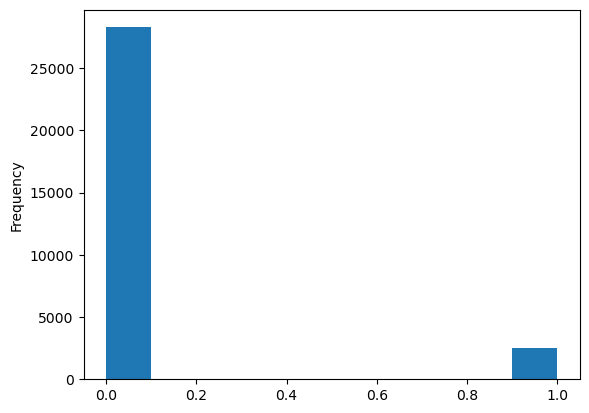

In [4]:
print(app_sample['TARGET'].value_counts())
app_sample['TARGET'].astype(int).plot.hist();

In [5]:
df1 = app_sample.copy()
target = app_sample['TARGET']
#summarize_dataframe(df1)


In [6]:
#dropping flag columns
flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
            'FLAG_DOCUMENT_20']
df1 = df1.drop(columns = flag_cols_to_drop)

This code snippet:
1. Identifies columns with `dtype: object` in `application_data`.
2. Converts these columns to categorical data types.
3. Applies one-hot encoding to these columns, creating new binary columns for each category. The resulting DataFrame, `df2`, contains the one-hot encoded features.

In [8]:
df2 = convert_to_categorical(df1)
df2 = encode_and_one_hot(df2)

Converted columns to categorical: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
DataFrame shape before encoding: (30751, 116)
0 columns were label encoded.
DataFrame shape after encoding: (30751, 221)


In [9]:
pd.options.display.max_columns = 200
print(df2.shape)
df2.describe()

(30751, 221)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,30751.000000,30751.000000,3.075100e+04,3.075100e+04,30751.000000,3.073000e+04,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,10427.000000,30751.0,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30750.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,13250.000000,30666.000000,24717.000000,15230.000000,12772.000000,15836.000000,10317.000000,9279.000000,14430.000000,15330.000000,15529.000000,9901.000000,12515.000000,9774.000000,15357.000000,9402.000000,13786.000000,15230.000000,12772.000000,15836.000000,10317.000000,9279.000000,14430.000000,15330.000000,15529.000000,9901.000000,12515.000000,9774.000000,15357.000000,9402.000000,13786.000000,15230.000000,12772.000000,15836.000000,10317.000000,9279.000000,14430.000000,15330.000000,15529.000000,9901.000000,12515.000000,9774.000000,15357.000000,9402.000000,13786.000000,15979.000000,30649.000000,30649.000000,30649.000000,30649.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,26694.000000,26694.000000,26694.000000,26694.000000,26694.000000,26694.000000
mean,0.080680,0.412117,1.694801e+05,5.959022e+05,27031.693164,5.355089e+05,0.020777,-16090.213391,65289.421092,-5016.161296,-3008.758902,11.959816,1.0,0.815811,0.199701,0.997919,0.278105,0.057494,2.150016,2.049689,2.029300,12.071087,0.015512,0.050307,0.040942,0.078274,0.228643,0.177035,0.502691,0.514601,0.510544,0.117145,0.088700,0.977565,0.753168,0.044027,0.078657,0.150571,0.225978,0.232015,0.066412,0.100614,0.107700,0.008433,0.029231,0.114057,0.087826,0.976770,0.760425,0.042121,0.074053,0.146110,0.222069,0.228070,0.064962,0.105629,0.106110,0.007707,0.027829,0.117514,0.088316,0.977574,0.756454,0.044036,0.077663,0.149994,0.225535,0.231649,0.067236,0.101906,0.108835,0.008240,0.029143,0.102627,1.438155,0.143333,1.420634,0.099905,-968.849989,0.705896,0.014731,0.090339,0.000228,0.082599,0.003415,0.004162,0.003512,0.002732,0.001561,0.009105,0.000260,0.008357,0.000683,0.000683,0.0

Based on the statistical summary, we observe that the 'DAYS_BIRTH' and 'DAYS_EMPLOYED' features have negative values. To improve interpretability, we'll transform these values to positive and convert them to years. Additionally, we noticed that 'DAYS_EMPLOYED' has an unusually large maximum value of 365243, likely indicates data errors or extreme outliers. Therefore, we'll replace these extreme values with missing values to ensure data quality. We also remove high values in the 'OBS_30_CNT_SOCIAL_CIRCLE' and 'OBS_60_CNT_SOCIAL_CIRCLE' columns by replacing them with NaN. Although these extreme values did not appear in this random sample, it’s important to address them for data consistency.


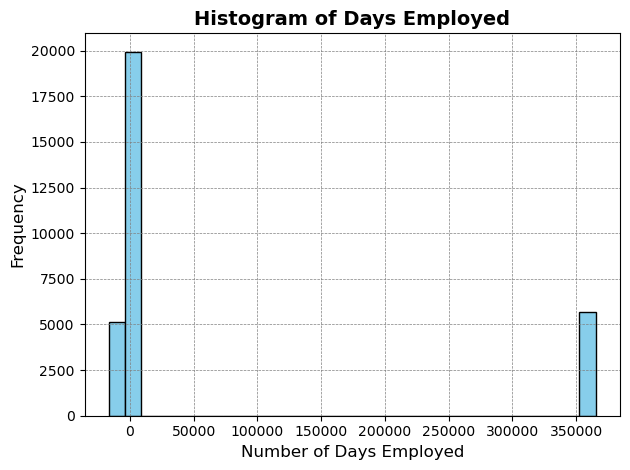

In [11]:
plot_histogram(df2, column='DAYS_EMPLOYED', title='Days Employed', xlabel='Number of Days Employed')

In [12]:
# Count values greater than 30 in the column 'OBS_30_CNT_SOCIAL_CIRCLE'
#count_greater_than_30 = (df2['OBS_60_CNT_SOCIAL_CIRCLE'] > 30).sum()
#print(count_greater_than_30)

In [13]:
# change days birth to positive values
df2['DAYS_BIRTH'] = df2['DAYS_BIRTH'] * (-1/ 365)
df2['DAYS_EMPLOYED'] = df2['DAYS_EMPLOYED'] * (-1/ 365)

# Create an anomalous flag column for this extreme case
df2['DAYS_EMPLOYED_ANOM'] = df2["DAYS_EMPLOYED"] >= df2["DAYS_EMPLOYED"].min()

# removing anomalous points
df2['DAYS_EMPLOYED'].replace({df2["DAYS_EMPLOYED"].min(): np.nan}, inplace = True)
df2.loc[df2['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
df2.loc[df2['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] = np.nan

df2[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']].describe()


,DAYS_BIRTH,DAYS_EMPLOYED,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
count,30751.000000,25089.000000,30649.000000,30649.000000
mean,44.082776,6.583781,1.438155,1.420634
std,11.995982,6.451045,2.351176,2.329988
min,21.035616,0.010959,0.000000,0.000000
25%,34.158904,2.112329,0.000000,0.000000
50%,43.309589,4.528767,0.000000,0.000000
75%,54.100000,8.775342,2.000000,2.000000
max,69.019178,44.863014,25.000000,25.000000


Now, we can clearly see the distribution of the 'DAYS_EMPLOYED' feature. Displaying it in terms of years employed provides a clearer and more meaningful understanding of its distribution.

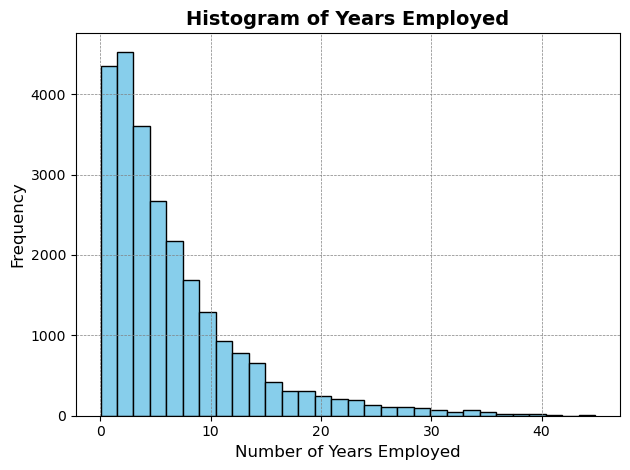

In [15]:
plot_histogram(df2, column='DAYS_EMPLOYED', title='Years Employed', xlabel='Number of Years Employed')

# Engineering new features

In [17]:
# Credit term in years
df2['CREDIT_TERM_YEARS'] = df2['AMT_CREDIT'] / df2['AMT_ANNUITY'] / 12
# Family size to income ratio
df2['INCOME_PER_FAMILY_MEMBER'] = df2['AMT_INCOME_TOTAL'] / df2['CNT_FAM_MEMBERS']
#income and credit features
df2['CREDIT_INCOME_RATIO'] = df2['AMT_CREDIT'] / (df2['AMT_INCOME_TOTAL'] + 0.00001)
df2['CREDIT_ANNUITY_RATIO'] = df2['AMT_CREDIT'] / (df2['AMT_ANNUITY'] + 0.00001)
df2['ANNUITY_INCOME_RATIO'] = df2['AMT_ANNUITY'] / (df2['AMT_INCOME_TOTAL'] + 0.00001)
df2['INCOME_ANNUITY_DIFF'] = df2['AMT_INCOME_TOTAL'] - df2['AMT_ANNUITY']
df2['INCOME_EXT_RATIO'] = df2['AMT_INCOME_TOTAL'] / (df2['EXT_SOURCE_3'] + 0.00001)
df2['CREDIT_EXT_RATIO'] = df2['AMT_CREDIT'] / (df2['EXT_SOURCE_3'] + 0.00001)
df2['CREDIT_GOODS_RATIO'] = df2['AMT_CREDIT'] / (df2['AMT_GOODS_PRICE'] + 0.00001)
df2['CREDIT_GOODS_DIFF'] = df2['AMT_CREDIT'] - df2['AMT_GOODS_PRICE'] + 0.00001
df2['GOODS_INCOME_RATIO'] = df2['AMT_GOODS_PRICE'] / (df2['AMT_INCOME_TOTAL'] + 0.00001)
#car ratios
df2['CAR_EMPLOYED_DIFF'] = df2['OWN_CAR_AGE'] - df2['DAYS_EMPLOYED']
df2['CAR_EMPLOYED_RATIO'] = df2['OWN_CAR_AGE'] / (df2['DAYS_EMPLOYED']+0.00001)
df2['CAR_AGE_DIFF'] = df2['DAYS_BIRTH'] - df2['OWN_CAR_AGE']
df2['CAR_AGE_RATIO'] = df2['OWN_CAR_AGE'] / (df2['DAYS_BIRTH'] + 0.00001)
#age ratios and diffs
df2['AGE_EMPLOYED_DIFF'] = df2['DAYS_BIRTH'] - df2['DAYS_EMPLOYED']
df2['EMPLOYED_TO_AGE_RATIO'] = df2['DAYS_EMPLOYED'] / (df2['DAYS_BIRTH'] + 0.00001)
#ext_sources
df2['EXT_SOURCE_MEAN'] = (df2['EXT_SOURCE_1'] + df2['EXT_SOURCE_2'] + df2['EXT_SOURCE_3'] ) / 3
df2['EXT_SOURCE_MUL'] = df2['EXT_SOURCE_1'] * df2['EXT_SOURCE_2'] * df2['EXT_SOURCE_3'] 
df2['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(df2['EXT_SOURCE_1'], df2['EXT_SOURCE_2'], df2['EXT_SOURCE_3'])]
df2['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(df2['EXT_SOURCE_1'], df2['EXT_SOURCE_2'], df2['EXT_SOURCE_3'])]
df2['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(df2['EXT_SOURCE_1'], df2['EXT_SOURCE_2'], df2['EXT_SOURCE_3'])]
df2['WEIGHTED_EXT_SOURCE'] =  df2.EXT_SOURCE_1 * 2 + df2.EXT_SOURCE_2 * 3 + df2.EXT_SOURCE_3 * 4

In [18]:
#apartment scores
df2['APARTMENTS_SUM_AVG'] = (df2['APARTMENTS_AVG'] + df2['BASEMENTAREA_AVG'] + df2['YEARS_BEGINEXPLUATATION_AVG'] + 
                            df2['YEARS_BUILD_AVG'] + df2['COMMONAREA_AVG'] + df2['ELEVATORS_AVG'] + 
                            df2['ENTRANCES_AVG'] + df2['FLOORSMAX_AVG'] + df2['FLOORSMIN_AVG'] + 
                            df2['LANDAREA_AVG'] + df2['LIVINGAPARTMENTS_AVG'] + df2['LIVINGAREA_AVG'] + 
                            df2['NONLIVINGAPARTMENTS_AVG'] + df2['NONLIVINGAREA_AVG'])
df2['APARTMENTS_SUM_MODE'] = (df2['APARTMENTS_MODE'] + df2['BASEMENTAREA_MODE'] + df2['YEARS_BEGINEXPLUATATION_MODE'] + 
                              df2['YEARS_BUILD_MODE'] + df2['COMMONAREA_MODE'] + df2['ELEVATORS_MODE'] + df2['ENTRANCES_MODE'] +
                              df2['FLOORSMAX_MODE'] + df2['FLOORSMIN_MODE'] + df2['LANDAREA_MODE'] + df2['LIVINGAPARTMENTS_MODE'] + 
                              df2['LIVINGAREA_MODE'] + df2['NONLIVINGAPARTMENTS_MODE'] + df2['NONLIVINGAREA_MODE'] + df2['TOTALAREA_MODE'])

df2['APARTMENTS_SUM_MEDI'] = (df2['APARTMENTS_MEDI'] + df2['BASEMENTAREA_MEDI'] + df2['YEARS_BEGINEXPLUATATION_MEDI'] + 
                              df2['YEARS_BUILD_MEDI'] + df2['COMMONAREA_MEDI'] + df2['ELEVATORS_MEDI'] + df2['ENTRANCES_MEDI'] + 
                              df2['FLOORSMAX_MEDI'] + df2['FLOORSMIN_MEDI'] + df2['LANDAREA_MEDI'] + df2['LIVINGAPARTMENTS_MEDI'] + 
                              df2['LIVINGAREA_MEDI'] + df2['NONLIVINGAPARTMENTS_MEDI'] + df2['NONLIVINGAREA_MEDI'])

df2['INCOME_APARTMENT_AVG_MUL'] = df2['APARTMENTS_SUM_AVG'] * df2['AMT_INCOME_TOTAL']
df2['INCOME_APARTMENT_MODE_MUL'] = df2['APARTMENTS_SUM_MODE'] * df2['AMT_INCOME_TOTAL']
df2['INCOME_APARTMENT_MEDI_MUL'] = df2['APARTMENTS_SUM_MEDI'] * df2['AMT_INCOME_TOTAL']

#flag contacts sum
df2['FLAG_CONTACTS_SUM'] = (df2['FLAG_MOBIL'] + df2['FLAG_EMP_PHONE'] + df2['FLAG_WORK_PHONE'] + 
                            df2['FLAG_CONT_MOBILE'] + df2['FLAG_PHONE'] + df2['FLAG_EMAIL'])

df2['HOUR_PROCESS_CREDIT_MUL'] = df2['AMT_CREDIT'] * df2['HOUR_APPR_PROCESS_START']
#family members
df2['CNT_NON_CHILDREN'] = df2['CNT_FAM_MEMBERS'] - df2['CNT_CHILDREN']
df2['CHILDREN_INCOME_RATIO'] = df2['CNT_CHILDREN'] / (df2['AMT_INCOME_TOTAL'] + 0.00001)
df2['PER_CAPITA_INCOME'] = df2['AMT_INCOME_TOTAL'] / (df2['CNT_FAM_MEMBERS'] + 1)
#region ratings
df2['REGIONS_RATING_INCOME_MUL'] = (df2['REGION_RATING_CLIENT'] + df2['REGION_RATING_CLIENT_W_CITY']) * df2['AMT_INCOME_TOTAL'] / 2
df2['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(df2['REGION_RATING_CLIENT'], df2['REGION_RATING_CLIENT_W_CITY'])]
df2['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(df2['REGION_RATING_CLIENT'], df2['REGION_RATING_CLIENT_W_CITY'])]
df2['REGION_RATING_MEAN'] = (df2['REGION_RATING_CLIENT'] + df2['REGION_RATING_CLIENT_W_CITY']) / 2
df2['REGION_RATING_MUL'] = df2['REGION_RATING_CLIENT'] * df2['REGION_RATING_CLIENT_W_CITY']


In [19]:
#flag regions
df2['FLAG_REGIONS'] = (df2['REG_REGION_NOT_LIVE_REGION'] + df2['REG_REGION_NOT_WORK_REGION'] + 
                      df2['LIVE_REGION_NOT_WORK_REGION']+df2['REG_CITY_NOT_LIVE_CITY'] + 
                      df2['REG_CITY_NOT_WORK_CITY'] + df2['LIVE_CITY_NOT_WORK_CITY'])

#OBS And DEF
df2['OBS_30_60_SUM'] = df2['OBS_30_CNT_SOCIAL_CIRCLE'] + df2['OBS_60_CNT_SOCIAL_CIRCLE']
df2['DEF_30_60_SUM'] = df2['DEF_30_CNT_SOCIAL_CIRCLE'] + df2['DEF_60_CNT_SOCIAL_CIRCLE']
df2['OBS_DEF_30_MUL'] = df2['OBS_30_CNT_SOCIAL_CIRCLE'] *  df2['DEF_30_CNT_SOCIAL_CIRCLE']
df2['OBS_DEF_60_MUL'] = df2['OBS_60_CNT_SOCIAL_CIRCLE'] *  df2['DEF_60_CNT_SOCIAL_CIRCLE']
df2['SUM_OBS_DEF_ALL'] = (df2['OBS_30_CNT_SOCIAL_CIRCLE'] + df2['DEF_30_CNT_SOCIAL_CIRCLE'] + 
                         df2['OBS_60_CNT_SOCIAL_CIRCLE'] + df2['DEF_60_CNT_SOCIAL_CIRCLE'])
df2['OBS_30_CREDIT_RATIO'] = df2['AMT_CREDIT'] / (df2['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
df2['OBS_60_CREDIT_RATIO'] = df2['AMT_CREDIT'] / (df2['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
df2['DEF_30_CREDIT_RATIO'] = df2['AMT_CREDIT'] / (df2['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
df2['DEF_60_CREDIT_RATIO'] = df2['AMT_CREDIT'] / (df2['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
#Flag Documents combined
df2['SUM_FLAGS_DOCUMENTS'] = (df2['FLAG_DOCUMENT_3'] + df2['FLAG_DOCUMENT_5'] + df2['FLAG_DOCUMENT_6']  +
                             df2['FLAG_DOCUMENT_7'] + df2['FLAG_DOCUMENT_8'] + df2['FLAG_DOCUMENT_9'] + 
                             df2['FLAG_DOCUMENT_11'] + df2['FLAG_DOCUMENT_13'] + df2['FLAG_DOCUMENT_14'] + 
                             df2['FLAG_DOCUMENT_15'] + df2['FLAG_DOCUMENT_16'] + df2['FLAG_DOCUMENT_17'] + 
                             df2['FLAG_DOCUMENT_18'] + df2['FLAG_DOCUMENT_19'] + df2['FLAG_DOCUMENT_21'])
#details change
df2['DAYS_DETAILS_CHANGE_MUL'] = df2['DAYS_LAST_PHONE_CHANGE'] * df2['DAYS_REGISTRATION'] * df2['DAYS_ID_PUBLISH']
df2['DAYS_DETAILS_CHANGE_SUM'] = df2['DAYS_LAST_PHONE_CHANGE'] + df2['DAYS_REGISTRATION'] + df2['DAYS_ID_PUBLISH']
#enquires
df2['AMT_ENQ_SUM'] = (df2['AMT_REQ_CREDIT_BUREAU_HOUR'] + df2['AMT_REQ_CREDIT_BUREAU_DAY'] + 
                      df2['AMT_REQ_CREDIT_BUREAU_WEEK'] + df2['AMT_REQ_CREDIT_BUREAU_MON'] + 
                      df2['AMT_REQ_CREDIT_BUREAU_QRT'] + df2['AMT_REQ_CREDIT_BUREAU_YEAR'])
df2['ENQ_CREDIT_RATIO'] = df2['AMT_ENQ_SUM'] / (df2['AMT_CREDIT'] + 0.00001)


The top 30 features with positive correlation to the 'TARGET' label now range from 0.028968 to 0.078938, while the top 30 features with negative correlation range from -0.037003 to -0.233053. Compared to the dataset without engineered new features, the correlations have slightly increased on both the positive and negative ends.

We’ll store these top 60 features in one dataset and keep the remaining features in another, along with all features from other datasets. To improve computational efficiency, speed, and reduce noise, we’ll apply Factor Analysis of Mixed Data (FAMD) to reduce the dimensionality of this combined dataset until we reach an accumulative variance of 70%.

In [21]:
target = df2['TARGET']
df2 = df2.drop(columns = 'TARGET')
top30_corr_column_names = get_top_correlations(df2, target,top_n=30)


Most Positive Correlations (Top 30):

 DAYS_DETAILS_CHANGE_SUM                              0.078938
CREDIT_GOODS_RATIO                                   0.076958
NAME_INCOME_TYPE_Working                             0.063799
REGION_RATING_MAX                                    0.063421
REGION_RATING_CLIENT_W_CITY                          0.063421
REGION_RATING_MUL                                    0.062589
REGION_RATING_MEAN                                   0.062337
DAYS_ID_PUBLISH                                      0.062250
REGION_RATING_CLIENT                                 0.059778
DAYS_DETAILS_CHANGE_MUL                              0.058482
FLAG_DOCUMENT_3                                      0.056257
CAR_EMPLOYED_DIFF                                    0.055383
DAYS_REGISTRATION                                    0.053531
REG_CITY_NOT_WORK_CITY                               0.052241
DAYS_LAST_PHONE_CHANGE                               0.051834
FLAG_EMP_PHONE                 

Most Positive Correlations (Top 5):

 DAYS_DETAILS_CHANGE_SUM        0.078938
CREDIT_GOODS_RATIO             0.076958
NAME_INCOME_TYPE_Working       0.063799
REGION_RATING_MAX              0.063421
REGION_RATING_CLIENT_W_CITY    0.063421
dtype: float64


Most Negative Correlations (Top 5):

 WEIGHTED_EXT_SOURCE   -0.233053
EXT_SOURCE_MEAN       -0.231549
EXT_SOURCE_MAX        -0.195642
EXT_SOURCE_MUL        -0.190636
EXT_SOURCE_3          -0.186173
dtype: float64


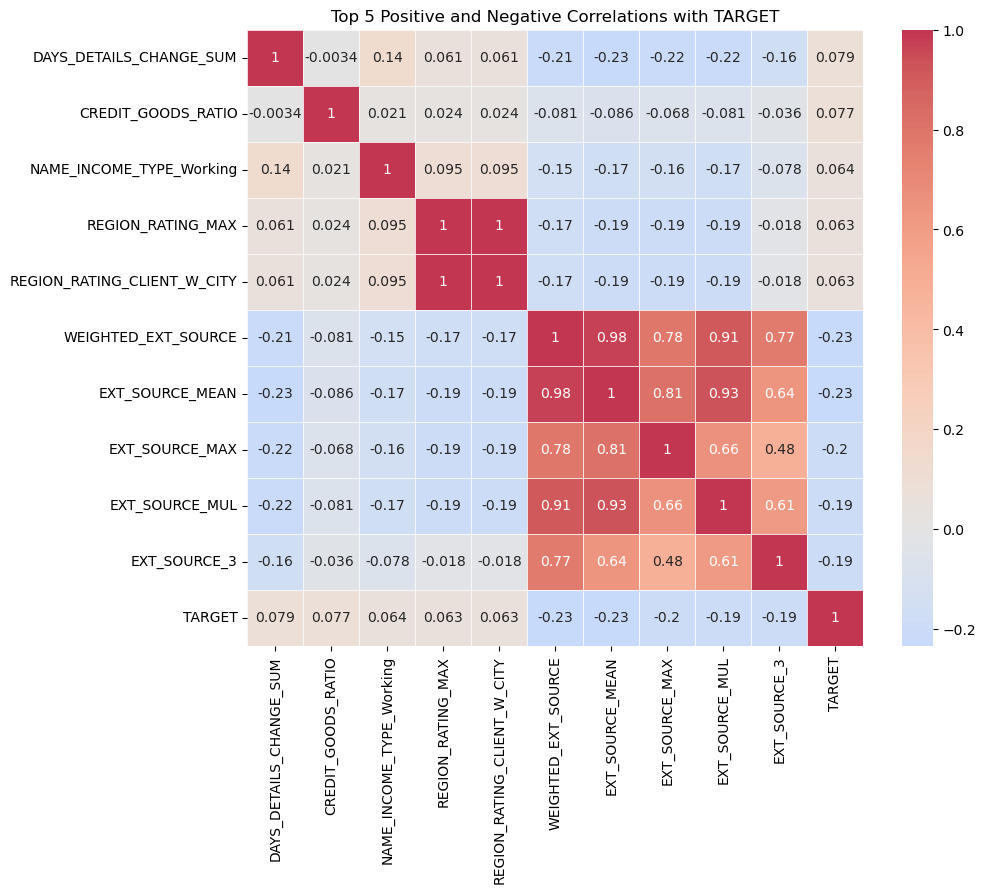

In [22]:
plot_top_correlation_heatmap(df2, target, top_n=5)

In [23]:
# data to predict the model
df3_new_features = df2[top30_corr_column_names]
df4_new_features = df2.drop(columns = top30_corr_column_names)

In [24]:
# Missing values statistics
missing_values = missing_values_table(df4_new_features)
missing_values.head(20)

Number of columns of this dataframe is 214.
Columns with missing values are 69.


,Missing Values,% of Total Values
INCOME_APARTMENT_MODE_MUL,22598,73.5
INCOME_APARTMENT_MEDI_MUL,22596,73.5
INCOME_APARTMENT_AVG_MUL,22596,73.5
COMMONAREA_AVG,21472,69.8
COMMONAREA_MEDI,21472,69.8
COMMONAREA_MODE,21472,69.8
NONLIVINGAPARTMENTS_MEDI,21349,69.4
NONLIVINGAPARTMENTS_AVG,21349,69.4
NONLIVINGAPARTMENTS_MODE,21349,69.4
CAR_EMPLOYED_RATIO,21340,69.4


In [25]:
# Save two data for model prediction
df3_new_features.to_csv(f'{config.CleanDataPath}df3_new_features.csv', index=True, index_label='SK_ID_CURR')
df4_new_features.to_csv(f'{config.CleanDataPath}df4_new_features.csv', index=True, index_label='SK_ID_CURR')